In [378]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

In [379]:
L = 10
N = 128
g = 9.81

In [380]:
n = (np.linspace(0, N-1, N)).astype(int)

nx, ny = np.meshgrid(n, n)
deltaK = 2*np.pi/L
uv = np.stack((nx, ny), axis=2)

In [381]:
K =  2*np.pi*(uv-0.5*N)
k = np.linalg.norm(K, axis=2)+0.00001
k = np.reshape(k, (*k.shape, 1))
omega = np.sqrt(g*k)

In [382]:
eta0 = np.random.normal(size=(N, N))
eta1 = np.random.normal(size=(N, N))

In [383]:
def Philips(K, L, w_dir, V, g):
    k = np.linalg.norm(K, axis=2)+0.00001
    k = np.reshape(k, (*k.shape, 1))
    L2 = V*V/g
    S=L2*np.exp(-1/np.power(k*L2, 2))
    S1=np.power(np.abs(np.dot(K/k, w_dir)), 4 ).reshape((k.shape[0], k.shape[0], 1))
    S2=np.power(k, 2)
    return  S*S1/S2#np.log(S)+np.log(S1)+np.log(S2)

def JW_wp(wind, fetch, g):
    return 2.84*np.power(g, 0.7)*np.power(fetch, -0.3)*np.power(wind, -0.4)

def JW_alpha(wind, w_p, g):
    return 0.033*np.power(w_p*wind/g, 2./3)

def JONSWAP(w, w_p, alpha=0.0081, gamma=3.3, beta=1.25, g=9.81):
    sigma = np.ones(w.shape)*1*(w<w_p)*0.07+np.ones(w.shape)*1*(w>=w_p)*0.09
    a = np.exp(-np.power(w-w_p, 2)*2/np.power(2*w_p*sigma, 2))
    S0 = alpha*g*g/np.power(w, 5)
    S1 = np.exp(-beta*np.power(w_p/w, 4))*np.power(gamma, a)
    return S0*S1

def JONSWAP_k(K, w_p, alpha=0.0081, gamma=3.3, beta=1.25, g=9.81):
    k = np.linalg.norm(K, axis=2)+0.00001
    k = np.reshape(k, (*k.shape, 1))
    omega = np.sqrt(g*k)
    return JONSWAP(omega, w_p, alpha, gamma, beta, g)*g/2/omega


In [402]:
wind = 5
wind_dir = np.array([1./np.sqrt(2), 1./np.sqrt(2)])
F = 1000

In [413]:
w_p = JW_wp(wind, F, 9.81)
alpha = JW_alpha(wind, w_p, 9.81)
D_theta = np.power(np.abs(np.dot(K/k, wind_dir)), 4)
P_k = JONSWAP_k(K, w_p, alpha)[:,:,0]*D_theta
P_minus_k = JONSWAP_k(-K, w_p, alpha)[:,:,0]*D_theta
omega = np.sqrt(g*k[:,:,0])
h_0_k = (eta0+1j*eta1)*np.sqrt(2*P_k*deltaK*deltaK)
h_0_minus_k = (eta0+1j*eta1)*np.sqrt(2*P_k*deltaK*deltaK)
t=1
h_k_t = 0.5*h_0_k*np.exp(-1j*omega*t)+0.5*h_0_k*np.exp(1j*omega*t)

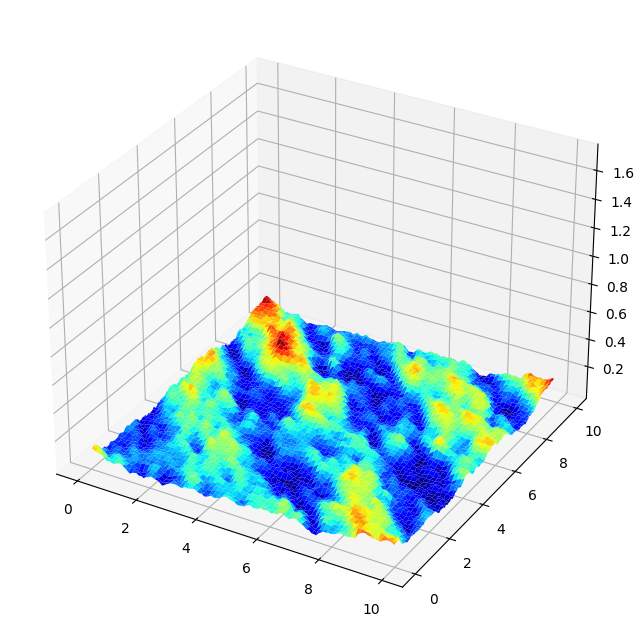

In [414]:
surf = np.absolute(np.fft.ifft2(h_k_t))
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(nx*L/N, ny*L/N, surf, cmap="jet", rcount=int(N/2), ccount=int(N/2))
ax.set_zlim3d(np.amin(surf), 10*np.amax(surf))
plt.show()